# Loading the data

In [ ]:
%pip install imblearn plotly

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
url = "https://raw.githubusercontent.com/franklin-univ-data-science/data/master/credit_default.csv"
data = pd.read_csv(url)

X = data.drop(columns=['ID', 'Y'])
y = data['Y']

c:\Users\Admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Exploration

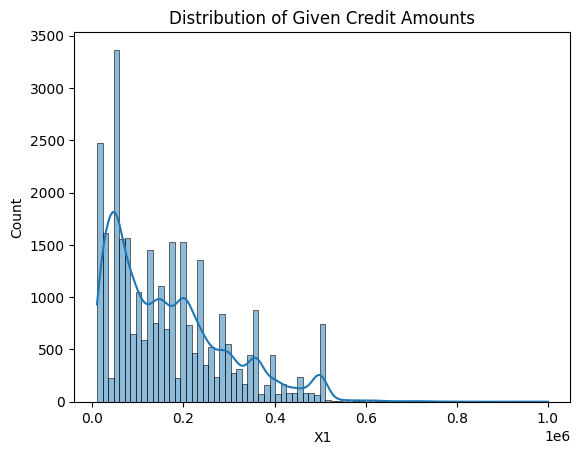

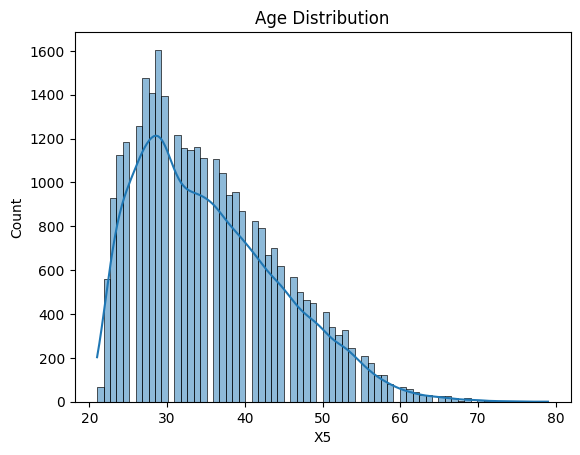

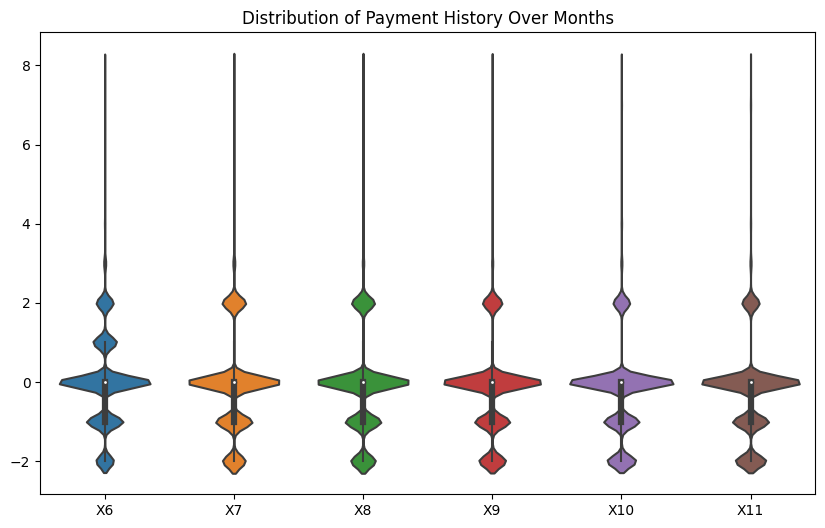

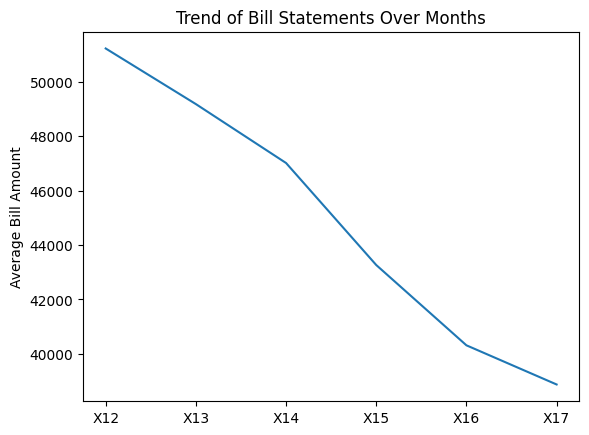

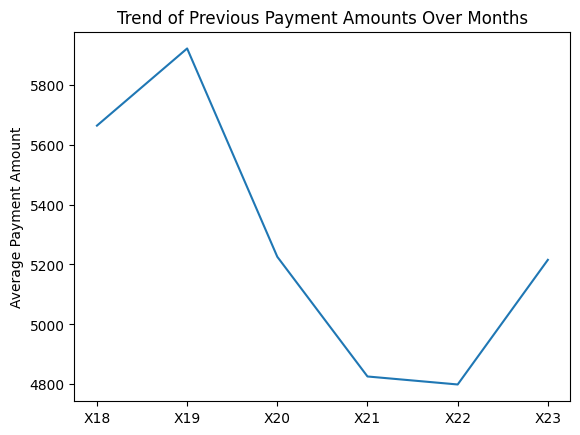

In [84]:
# Visualizations

sns.histplot(data=X, x='X1', kde=True)
plt.title('Distribution of Given Credit Amounts')
plt.show()

sns.histplot(data=X, x='X5', kde=True)
plt.title('Age Distribution')
plt.show()

payment_cols = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11']
plt.figure(figsize=(10,6))
sns.violinplot(data=X[payment_cols])
plt.title('Distribution of Payment History Over Months')
plt.show()

bill_cols = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17']
X[bill_cols].mean().plot()
plt.title('Trend of Bill Statements Over Months')
plt.ylabel('Average Bill Amount')
plt.show()

payment_amount_cols = ['X18', 'X19', 'X20', 'X21', 'X22', 'X23']
X[payment_amount_cols].mean().plot()
plt.title('Trend of Previous Payment Amounts Over Months')
plt.ylabel('Average Payment Amount')
plt.show()

# Data Preprocessing

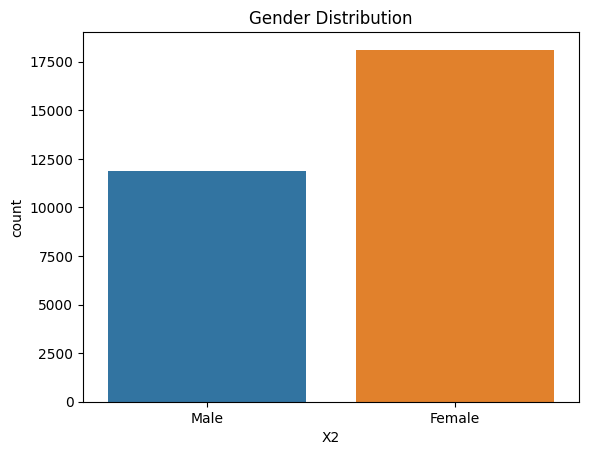

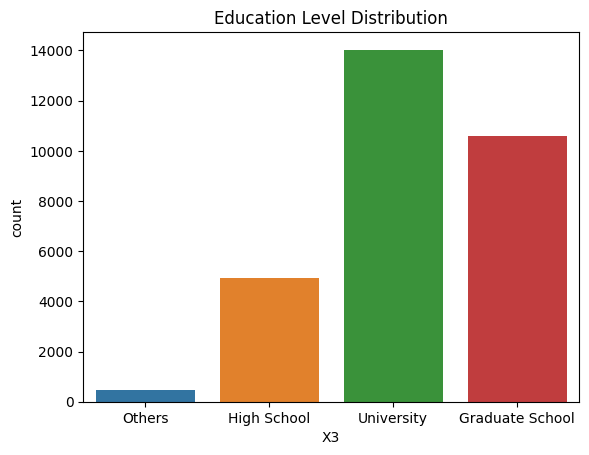

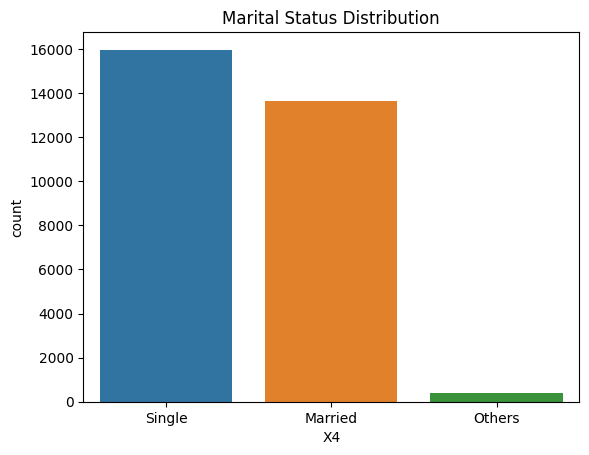

Explained variance by each component: [0.70968075 0.12258044 0.06796805]


In [85]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import plotly.express as px

# Are payments consistent?
# Add interaction term to address potential feature interaction
X['X18_X19_ratio'] = X['X18'] / (X['X19'] + 1e-10)  # Avoid division by zero, adding small constant
X['X18_X20_ratio'] = X['X18'] / (X['X20'] + 1e-10)
X['X18_X21_ratio'] = X['X18'] / (X['X21'] + 1e-10)
X['X18_X22_ratio'] = X['X18'] / (X['X22'] + 1e-10)
X['X18_X23_ratio'] = X['X18'] / (X['X23'] + 1e-10)

X['X19_X20_ratio'] = X['X19'] / (X['X20'] + 1e-10)
X['X19_X21_ratio'] = X['X19'] / (X['X21'] + 1e-10)
X['X19_X22_ratio'] = X['X19'] / (X['X22'] + 1e-10)
X['X19_X23_ratio'] = X['X19'] / (X['X23'] + 1e-10)

X['X20_X21_ratio'] = X['X20'] / (X['X21'] + 1e-10)
X['X20_X22_ratio'] = X['X20'] / (X['X22'] + 1e-10)
X['X20_X23_ratio'] = X['X20'] / (X['X23'] + 1e-10)

X['X21_X22_ratio'] = X['X21'] / (X['X22'] + 1e-10)
X['X21_X23_ratio'] = X['X21'] / (X['X23'] + 1e-10)

X['X22_X23_ratio'] = X['X22'] / (X['X23'] + 1e-10)

X['X2'] = X['X2'] - 1

sns.countplot(data=X, x='X2')
plt.title('Gender Distribution')
plt.xticks(ticks=[0,1], labels=['Male', 'Female'])
plt.show()

# Map education values to be in order of education level
def map_education(education):
    if education == 1:
        return 4
    if education == 2:
      return 3
    if education == 3:
      return 2
    else:
      return 0

X['X3'] = X['X3'].apply(map_education)

sns.countplot(data=X, x='X3')
plt.title('Education Level Distribution')
plt.xticks(ticks=[0,1,2,3], labels=['Others', 'High School', 'University', 'Graduate School'])
plt.show()

# Map marital status values
def map_marital(status):
    if status == 1:
        return 1
    if status == 2:
      return 0
    else:
        return 2

X['X4'] = X['X4'].apply(map_marital)

sns.countplot(data=X, x='X4')
plt.title('Marital Status Distribution')
plt.xticks(ticks=[0,1,2], labels=['Single', 'Married', 'Others'])
plt.show()

def opposite_month_map(val):
    if val == -1:
        return 0  # Duly payment
    else:
        return -(val)  # Negative values for months behind
for col in ["X6", "X7", "X8", "X9", "X10", "X11"]:
    X[col] = X[col].apply(opposite_month_map)

X["total_payment_score"] = X[["X6", "X7", "X8", "X9", "X10", "X11"]].sum(axis=1)
X["average_payment_score"] = X[["X6", "X7", "X8", "X9", "X10", "X11"]].mean(axis=1)

# Apply PCA to reduce multicollinearity among features
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X[['X6', 'X7', 'X8', 'X9', 'X10', 'X11']])
print(f"Explained variance by each component: {pca.explained_variance_ratio_}")  # Check explained variance

# Add PCA components to data and remove original features
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X = pd.concat([X, principal_df], axis=1)
X = X.drop(columns=['X6', 'X7', 'X8', 'X9', 'X10', 'X11'])

# Create the 3D scatter plot
fig = px.scatter_3d(X, x='PC1', y='PC2', z='PC3',
                    color=y,
                    color_continuous_scale='viridis',  # You can choose other color scales too
                    opacity=0.6,
                    width=800,
                    height=600)
fig.show()

# Applying SMOTE to address class imbalance in the training data
smote = SMOTE(random_state=123)
X, y = smote.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Data Modeling

In [86]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier with the best parameters
best_rf_clf = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=150,
    random_state=123,
    n_jobs=-1
)

# Train the classifier on the resampled training data
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=150, n_jobs=-1,
                       random_state=123)

# Data Evaluation

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4620
           1       0.90      0.84      0.87      4726

    accuracy                           0.87      9346
   macro avg       0.87      0.87      0.87      9346
weighted avg       0.87      0.87      0.87      9346

Accuracy: 0.8711748341536486
AUC-ROC: 0.9340939547826979


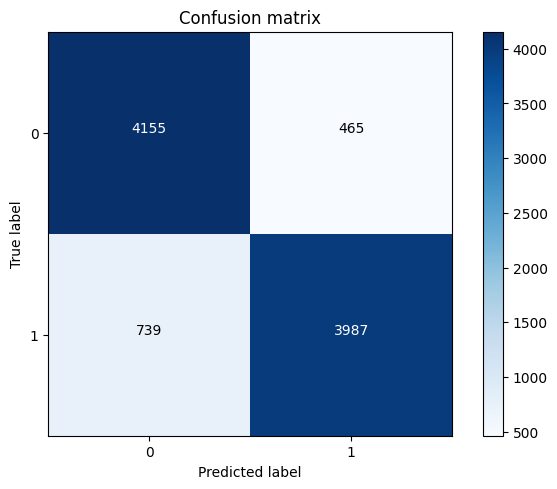

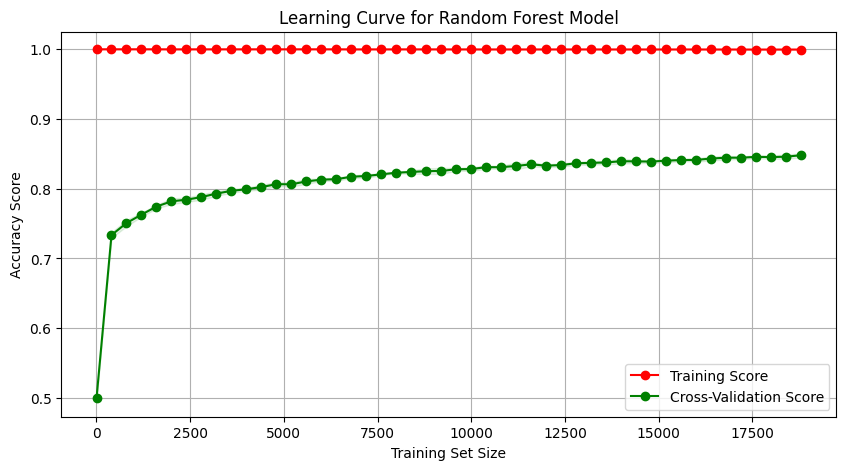

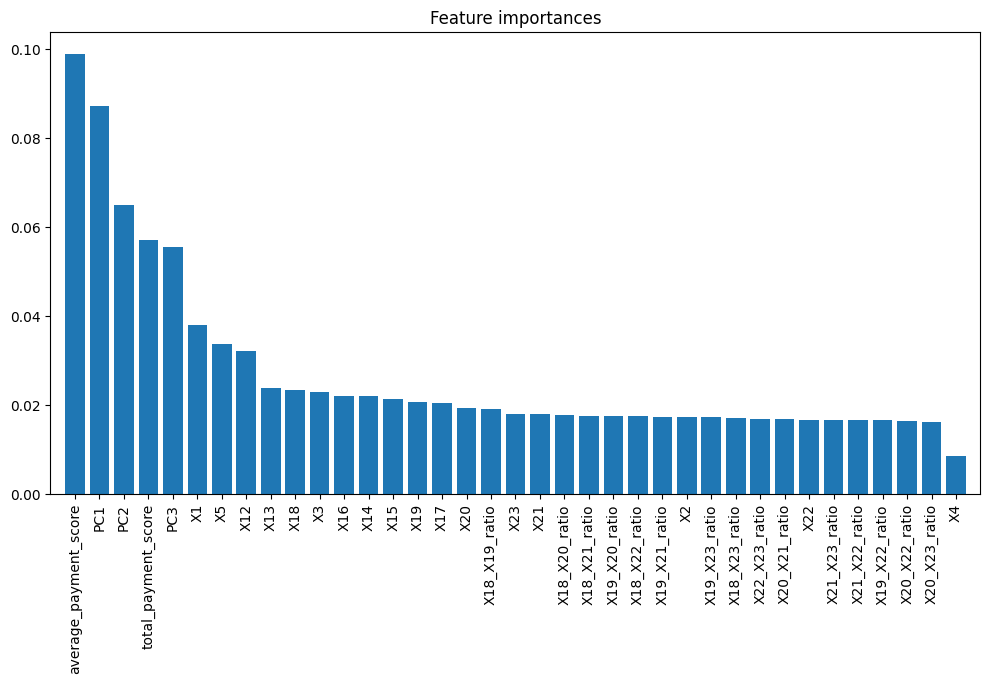

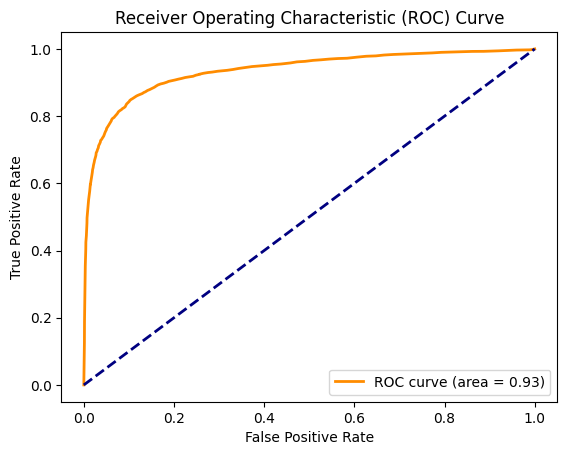

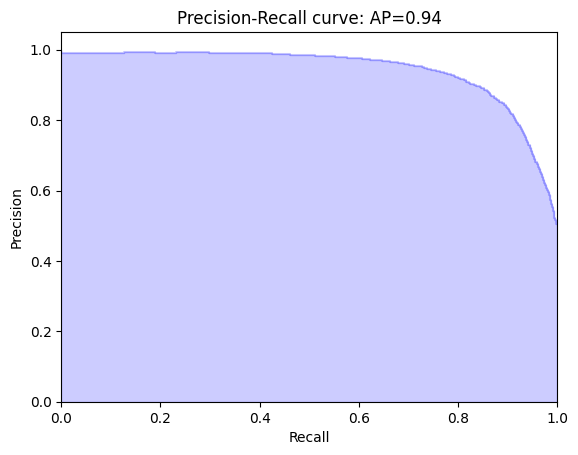

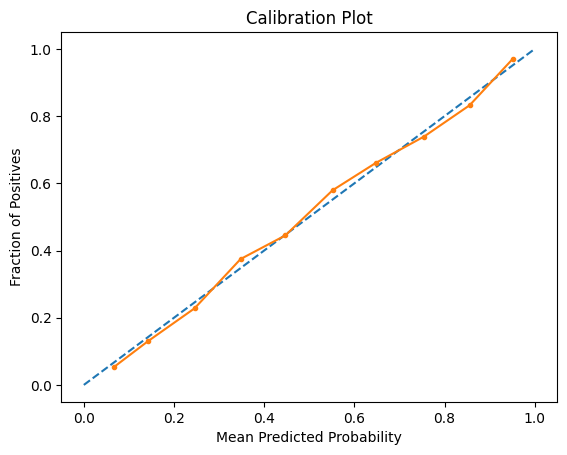

In [87]:
from sklearn.model_selection import learning_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import itertools
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Model evaluation
y_pred = best_rf_clf.predict(X_test)
y_pred_prob = best_rf_clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, best_rf_clf.predict_proba(X_test)[:, 1])}")

# Confusion Matrix Visualization
def plot_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
plot_matrix(cm, classes=[0, 1])

# Learning Curve Visualization
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_rf_clf,
    X=X_train,  # Training data
    y=y_train,  # Training targets
    train_sizes=np.arange(1, 19200, 400),  # This gives points at every 1000 records up to 24000.
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all processors for speed
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.title("Learning Curve for Random Forest Model")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

# Feature Importance Visualization
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

# Calibration Plot
calibrated_clf = CalibratedClassifierCV(best_rf_clf, method='sigmoid', cv=5, n_jobs=-1)
calibrated_clf.fit(X_train, y_train)
prob_true, prob_pred = calibration_curve(y_test, calibrated_clf.predict_proba(X_test)[:,1], n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.show()